## Don't Use FE/H or M/H grads derived with this code

In [1]:
##################################
### Import the usual libraries ###
##################################

#numpy
import numpy as np

# scipy
from scipy.stats import binned_statistic

#astropy
import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column, QTable

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.offsetbox import AnchoredText

# Yumi's Code to convert (RA,DEC) to MS coordinates
import MagellanicStream as ms

# .py files for grad calc
import astrofunctions as astro
import lmcgeometry as lgeo
import mlefitting as mle
import utilities as util

# Ignore warnings unless crashes
import warnings
warnings.filterwarnings('ignore')

#progress bars
from tqdm import tqdm_notebook

In [2]:
# PARSEC Isochrones
parsecall = ascii.read('/Users/joshpovick/Desktop/Research/LMC_Ages/parsec3_3.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

# LMC r13 data
lmcr13 = fits.getdata('lmc_rgbmembers.r13-l33-58672.fits.gz',1)
clnr = np.where((lmcr13['FE_H']>-9999.0)&(lmcr13['AK_TARG']>-9999.0)&(lmcr13['LOGG']>0.0)&
                (lmcr13['M_H_ERR']>-90.0)&(lmcr13['C_FE']>-9999.0)&(lmcr13['N_FE']>-9999.0))

r13 = lmcr13[clnr]

# PCA OLS Ages
ages = fits.getdata('../LMC_Ages/pca_ols_ages.fits')

In [3]:
### Radii LMC
x,y,dist = lgeo.LMCdisk_cart(r13['RA'],r13['DEC'])
radius = lgeo.elliptical_radius(x,y)
     
### All elements APOGEE measures abundances for
elems = ['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','P_FE','S_FE','K_FE','CA_FE','TI_FE',
         'TIII_FE','V_FE','CR_FE','MN_FE','FE_H','CO_FE','NI_FE','CU_FE','GE_FE','RB_FE','CE_FE','ND_FE','YB_FE']
elems_err = ['M_H_ERR','C_FE_ERR','N_FE_ERR','O_FE_ERR','NA_FE_ERR','MG_FE_ERR','AL_FE_ERR','SI_FE_ERR',
             'P_FE_ERR','S_FE_ERR','K_FE_ERR','CA_FE_ERR','TI_FE_ERR','TIII_FE_ERR','V_FE_ERR','CR_FE_ERR',
             'MN_FE_ERR','FE_H_ERR','CO_FE_ERR','NI_FE_ERR','CU_FE_ERR','GE_FE_ERR','RB_FE_ERR','CE_FE_ERR',
             'ND_FE_ERR','YB_FE_ERR']

labs = ['[M/H]','[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[P/Fe]','[S/Fe]','[K/Fe]',
        '[Ca/Fe','[Ti/FE]','[Ti II/Fe]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Cu/Fe]',
        '[Ge/Fe]','[Rb/Fe]','[Ce/Fe]','[Nd/Fe]','[Yb/FE]']

In [13]:
##############################
### Fit Overall Trendlines ###
##############################

med_ms = []
med_bs = []

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((r13[elems[i]]>-100)&(r13['SNR']>=100))
    
    # fit data
    dat_errs = np.sqrt(np.square(r13[elems_err[i]][cln])+np.square(r13['FE_H_ERR'][cln]))
    slope, inter = mle.mle_fit(radius[cln],r13[elems[i]][cln]+r13['FE_H'][cln],dat_errs)
    med_ms.append(slope)
    med_bs.append(inter)

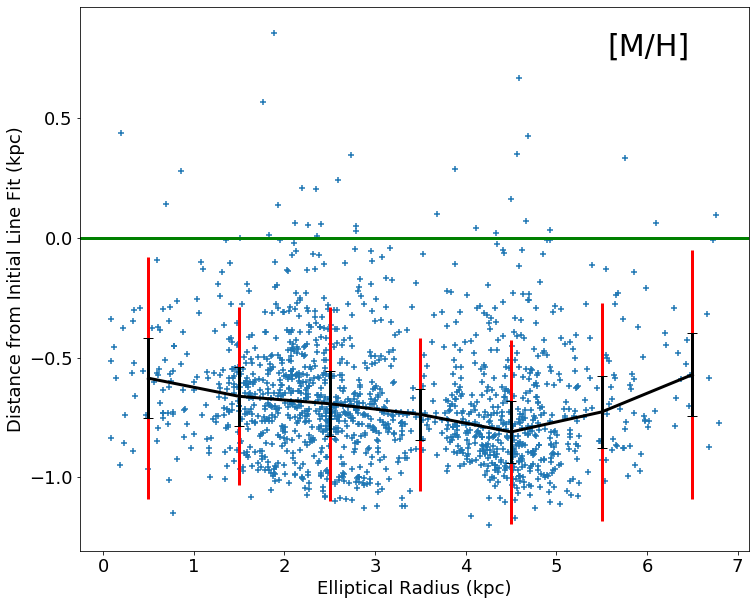

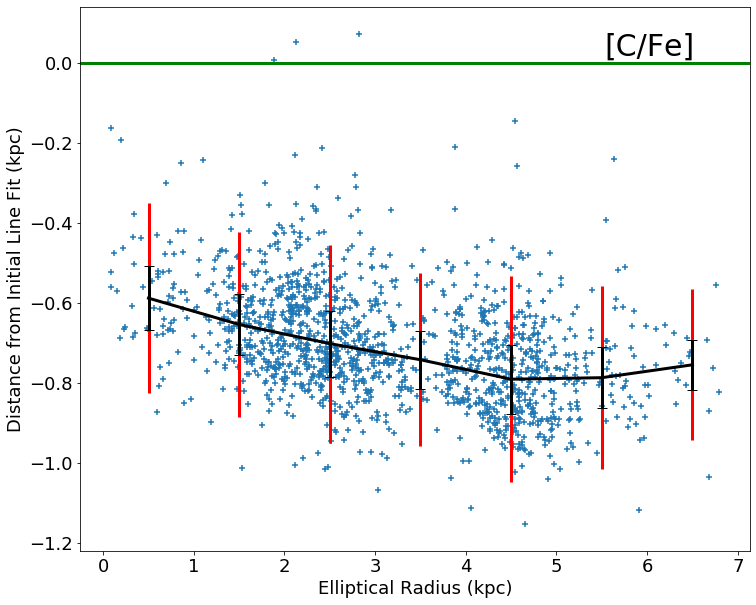

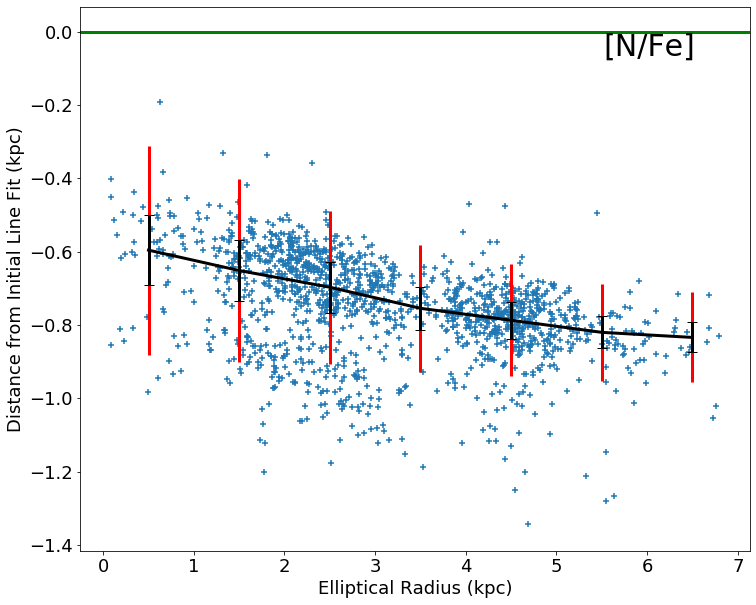

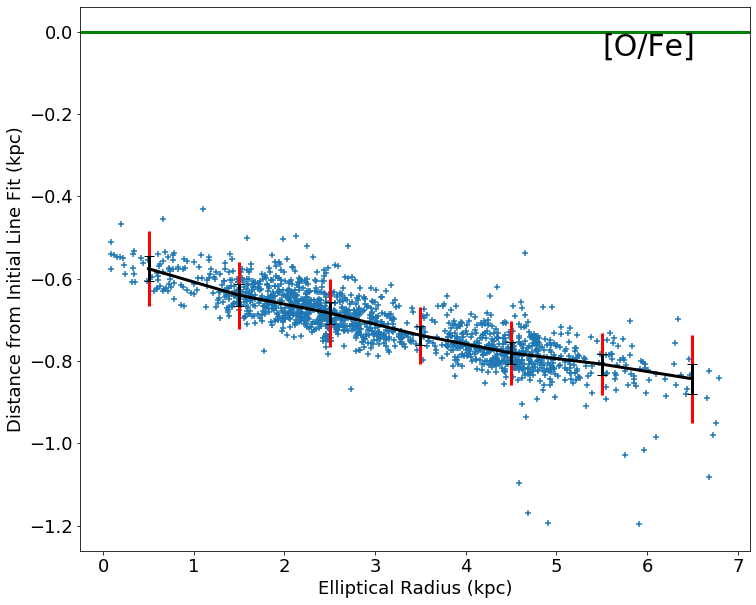

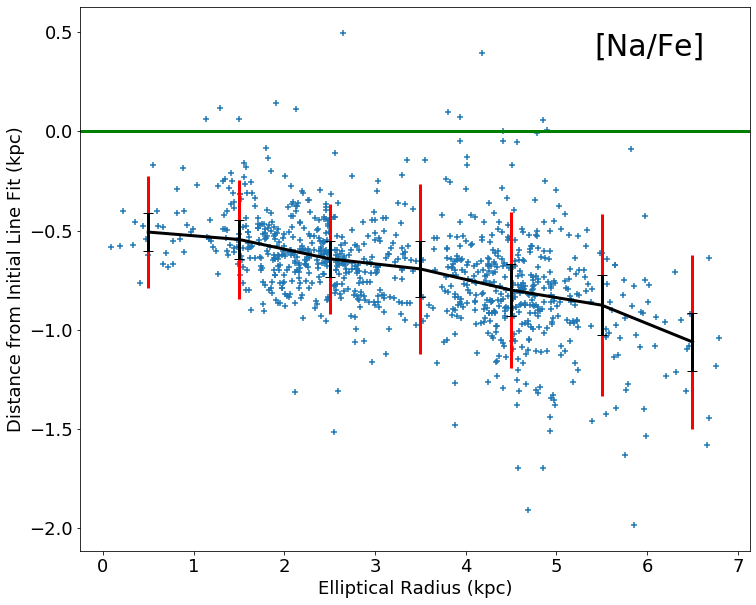

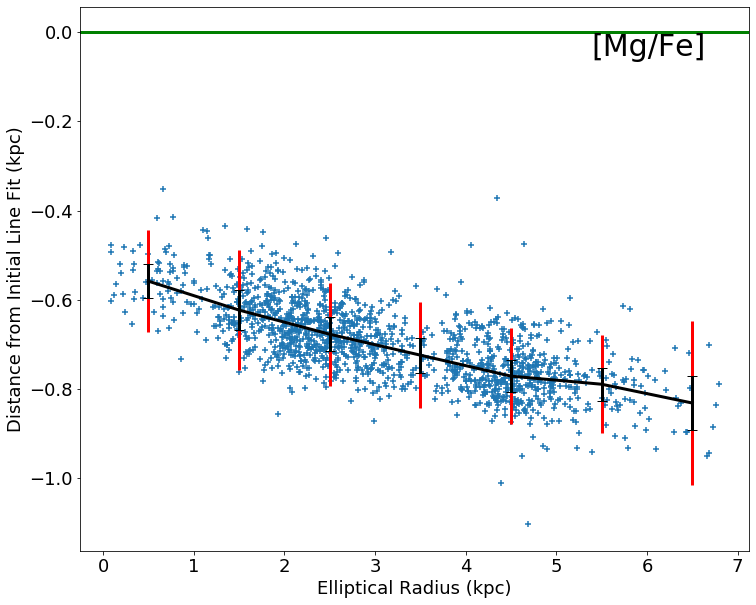

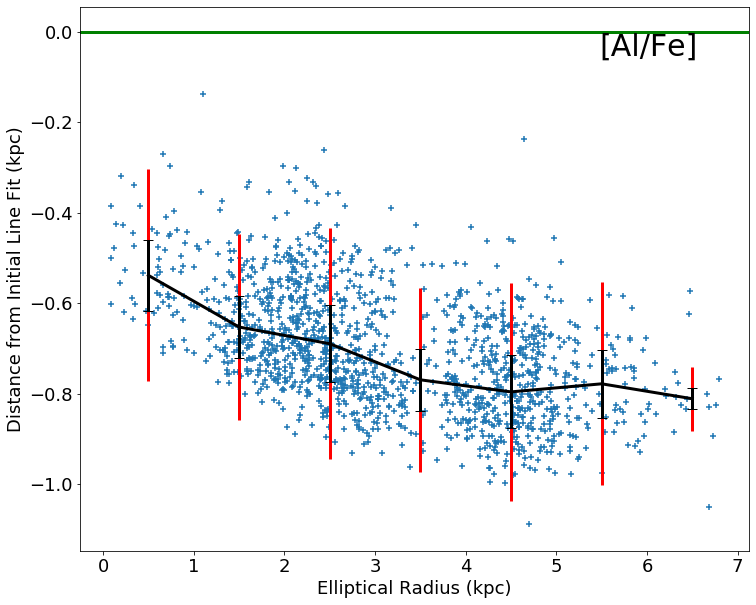

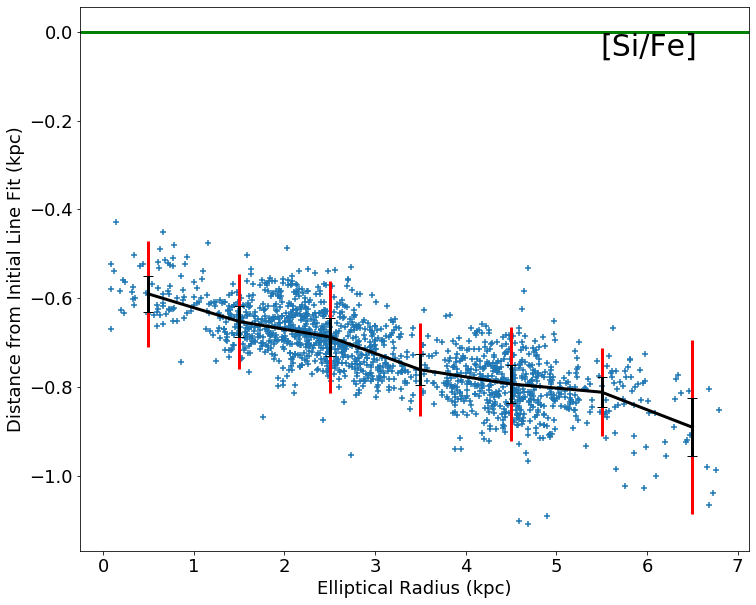

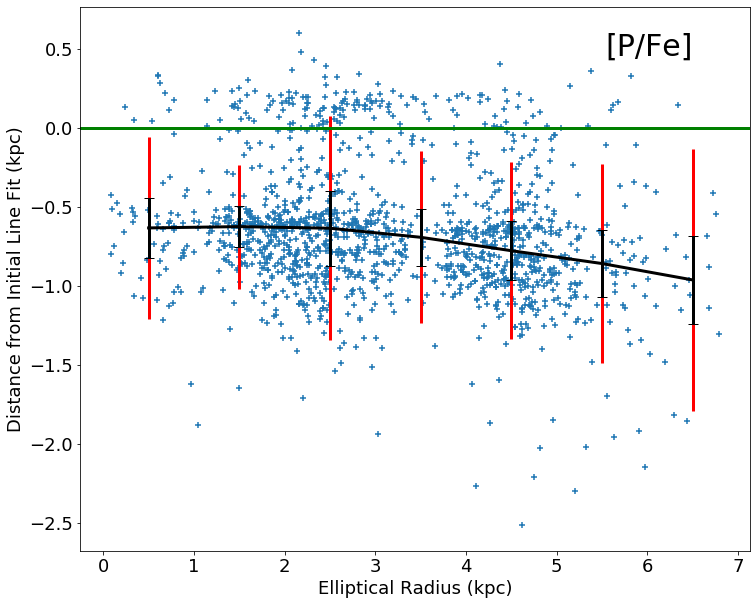

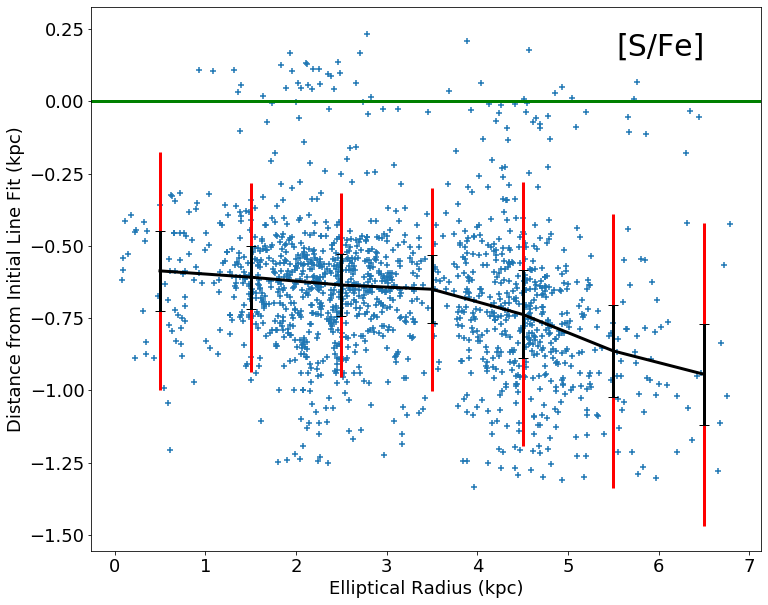

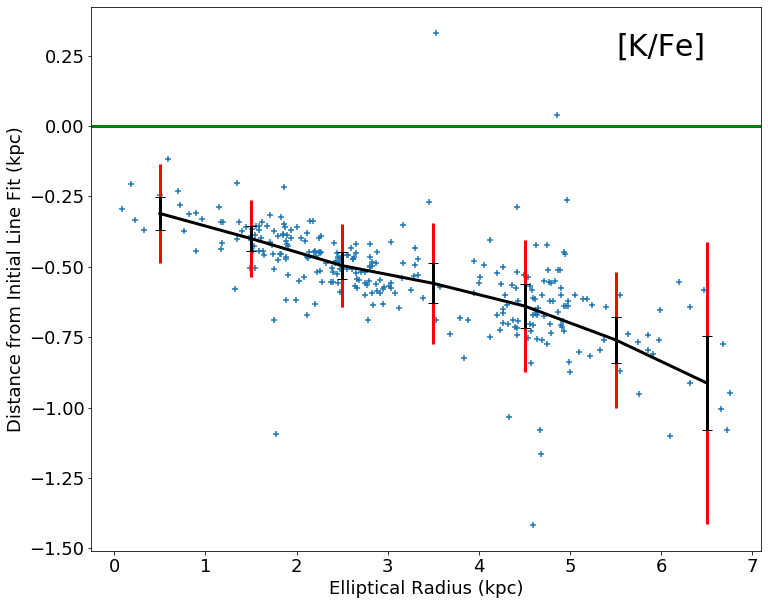

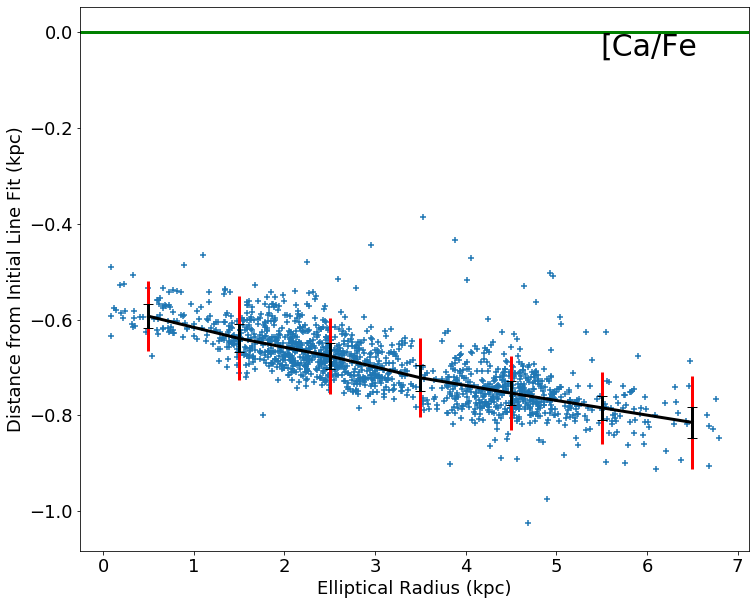

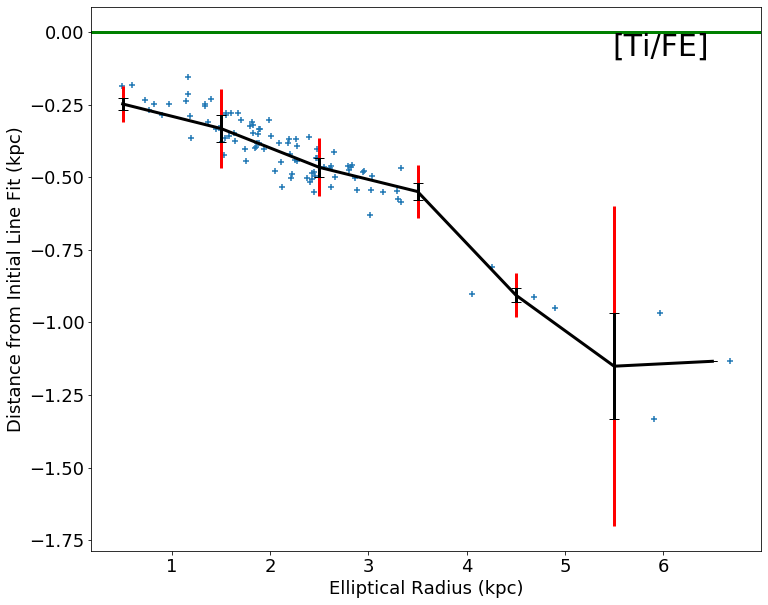

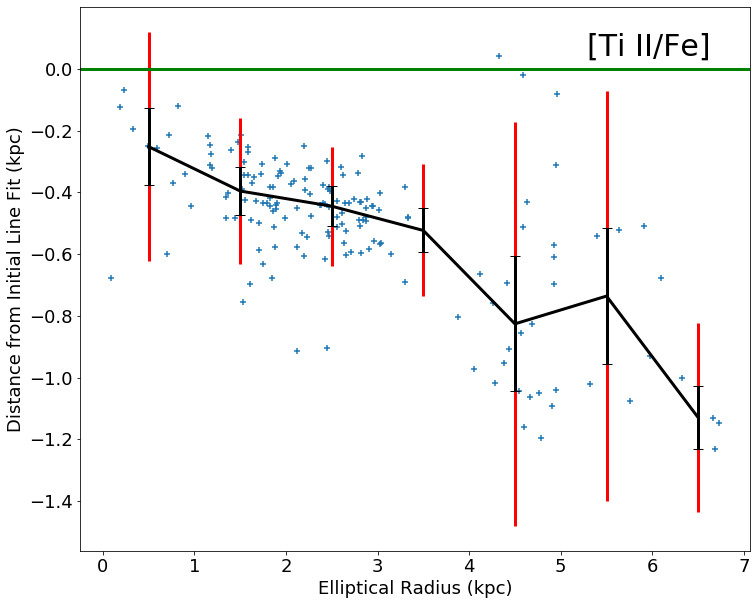

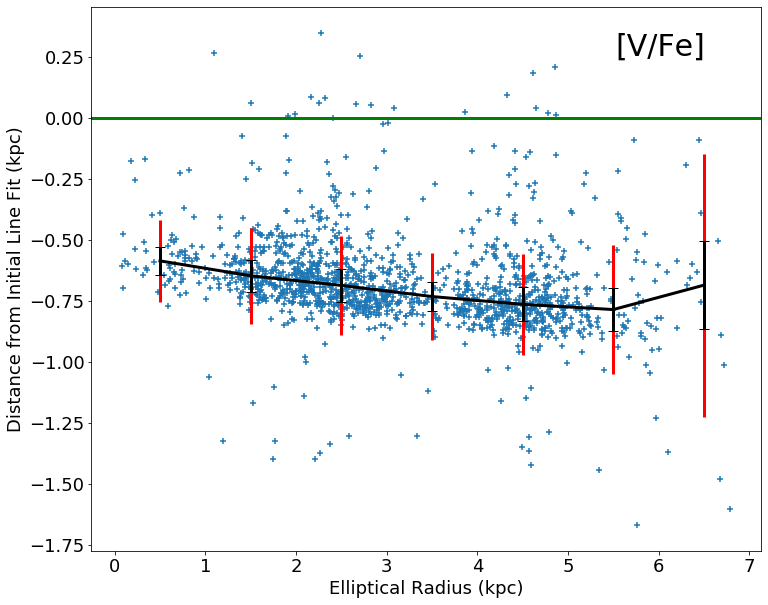

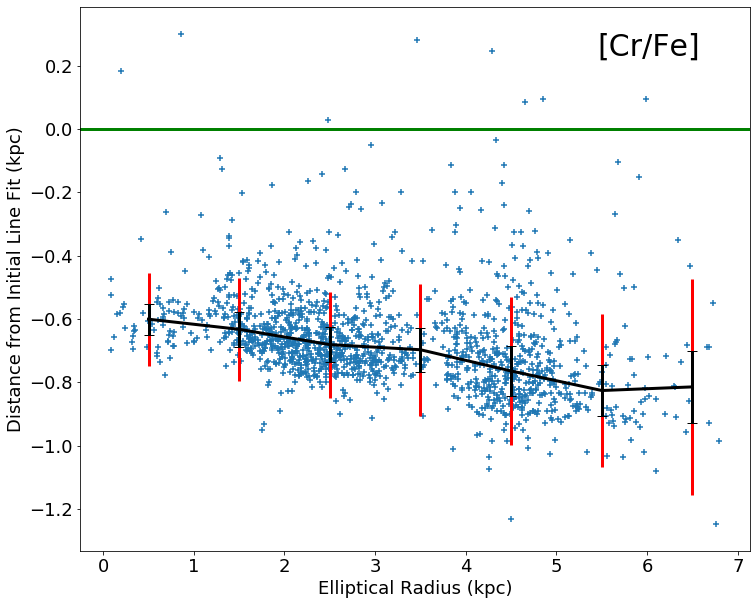

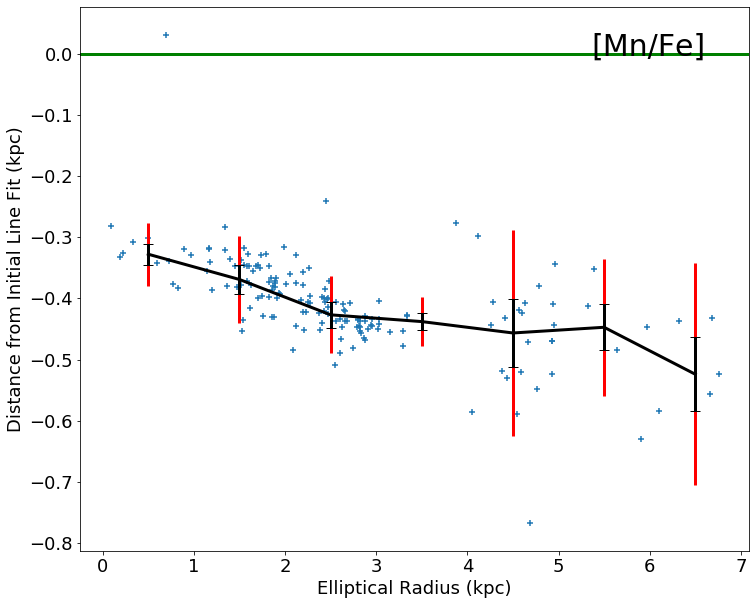

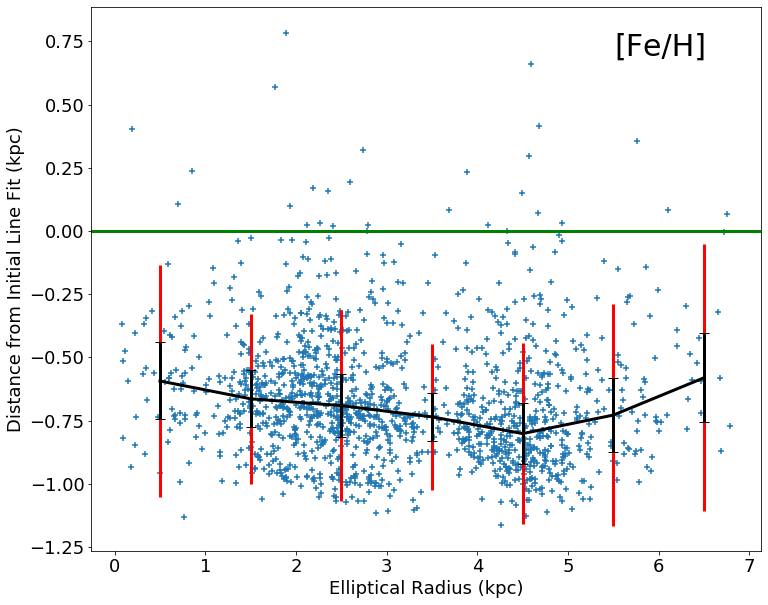

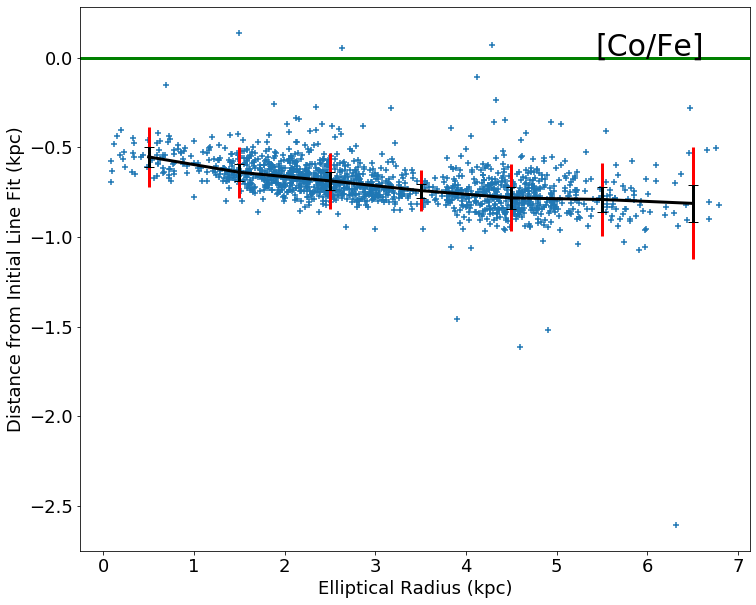

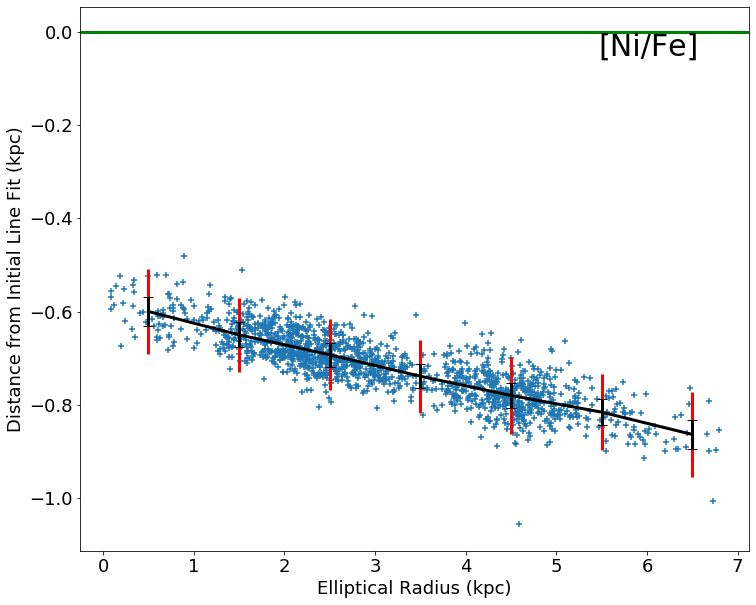

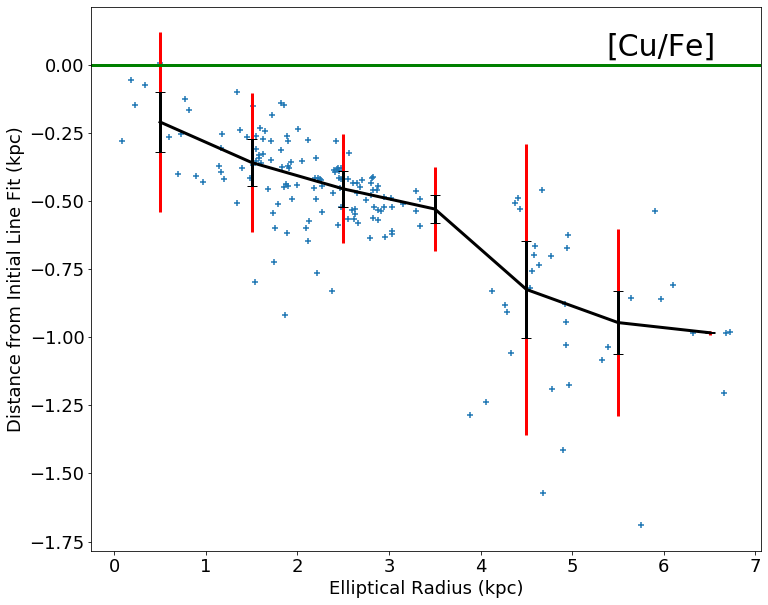

In [14]:
matplotlib.rcParams.update({'font.size': 18})
med_elems_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return med_ms[i]*x+med_bs[i]
    
    cln = np.where((r13[elems[i]]>-100)&(r13['SNR']>=100))
    plug = trendline(radius[cln])
    dist = plug-r13[elems[i]][cln]
    
    med_elems_dist.append(dist)    
    
    bins = np.append(np.arange(np.floor(np.min(radius[cln])),np.ceil(np.max(radius[cln])),1.0),
                     np.ceil(np.max(radius[cln]))+1) 
    bin_dist, _, _ = binned_statistic(radius[cln],dist,statistic='median',bins=bins)
    bin_spr, _, _ = binned_statistic(radius[cln],dist,statistic=lambda y: np.median(np.absolute(y-np.median(y))),
                                     bins=bins)
    
    plt.figure(figsize=[12,10])
    plt.scatter(radius[cln],dist,marker='+')
    plt.errorbar(bins[:-1]+0.5,bin_dist,yerr=3*bin_spr,c='r',ls='none',lw=3)
    plt.errorbar(bins[:-1]+0.5,bin_dist,yerr=bin_spr,c='k',capsize=5,lw=3)
    plt.axhline(0.0,c='g',lw=3.0)
    plt.title(r'{}'.format(labs[i]),fontsize=30,x=0.85,y=0.90)#,len(np.squeeze(cln))))
    plt.xlabel(r'Elliptical Radius (kpc)')
    plt.ylabel(r'Distance from Initial Line Fit (kpc)')
#     plt.savefig('outliers{}'.format(elems[i]),bbox_inches='tight')
    plt.show()

In [8]:
med_m_devs = []
med_b_devs = []
re_med_ms = []
re_med_bs = []

prune_fact = 3.
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((r13[elems[i]]>-100)&(r13['SNR']>=100))
    prune = np.where((r13[elems[i]]>-prune_fact*util.mad(med_elems_dist[i])+
                      np.median(r13[cln][elems[i]]))&
                     (r13[elems[i]]<prune_fact*util.mad(med_elems_dist[i])+
                      np.median(r13[cln][elems[i]])))

    exog = radius[prune]
    endog = (r13[elems[i]]+r13['FE_H'])[prune]
    endog_err = np.sqrt(np.square(r13[elems_err[i]][prune])+np.square(r13['FE_H_ERR'][prune]))
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    med_m_devs.append(util.mad(slps))
    med_b_devs.append(util.mad(ints))
    
    re_med_ms.append(np.median(slps))
    re_med_bs.append(np.median(ints))

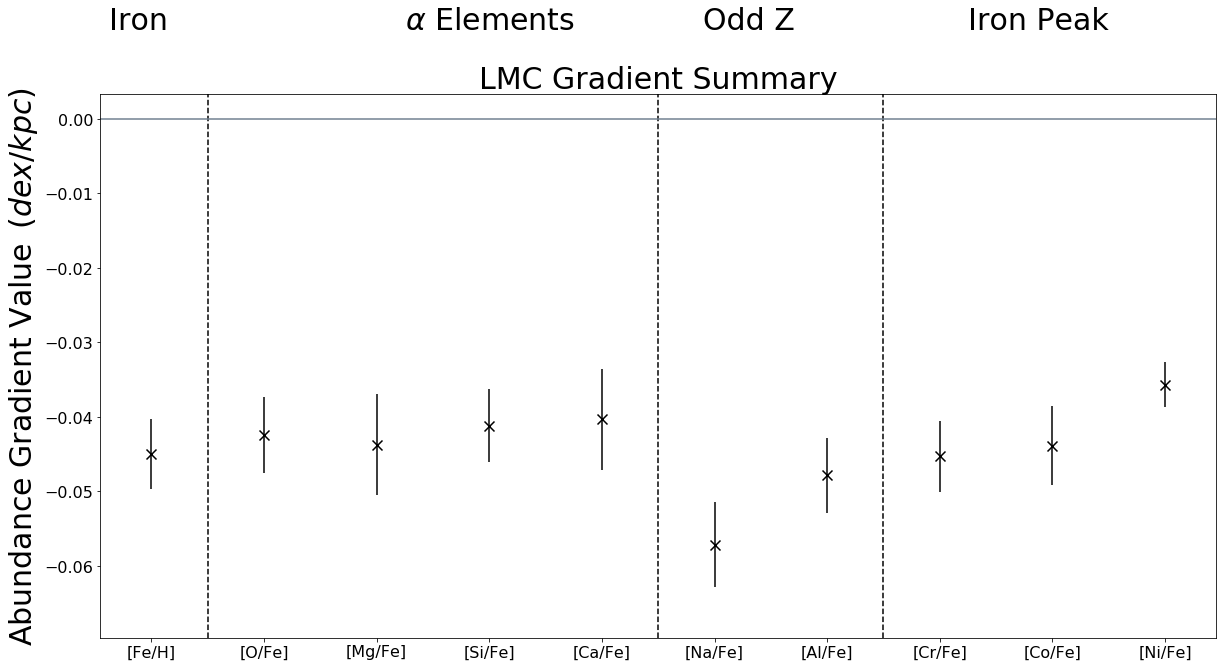

In [9]:
idx = [np.squeeze(np.where(np.asarray(elems)=='FE_H')),np.squeeze(np.where(np.asarray(elems)=='O_FE')),
       np.squeeze(np.where(np.asarray(elems)=='MG_FE')),np.squeeze(np.where(np.asarray(elems)=='SI_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CA_FE')),np.squeeze(np.where(np.asarray(elems)=='NA_FE')),
       np.squeeze(np.where(np.asarray(elems)=='AL_FE')),np.squeeze(np.where(np.asarray(elems)=='CR_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CO_FE')),np.squeeze(np.where(np.asarray(elems)=='NI_FE'))]

good_over = []
err_over = []

good_med = []
err_med = []

for i in idx:
    good_over.append(re_med_ms[i])
    err_over.append(med_m_devs[i])
    
#     good_med.append(med_m[i])

matplotlib.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=[20,10])

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_over,marker='x',c='black',label='Overall',s=100)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_over,yerr=err_over,c='black',ls='none')

#plt.scatter([0,1,2,3,4,5,6,7,8,9],good_med,marker='x',c='red',label='0.5 kpc bins',s=100)

xplotlab = ['[Fe/H]','[O/Fe]','[Mg/Fe]','[Si/Fe]','[Ca/Fe]','[Na/Fe]','[Al/Fe]','[Cr/Fe]','[Co/Fe]','[Ni/Fe]']
xplotpos = [0,1,2,3,4,5,6,7,8,9] 
plt.xticks(xplotpos,xplotlab)

plt.axvline(0.5,c='k',ls='--')
plt.axvline(4.5,c='k',ls='--')
plt.axvline(6.5,c='k',ls='--')
plt.axhline(0.0,c='slategrey',ls='-')
plt.ylabel('Abundance Gradient Value $\,(dex/kpc)$',fontsize=30)

# plt.gca().set_ylim(top=0.05)

plt.text(-0.375,0.012,'Iron',fontsize=30)
plt.text(2.25,0.012,'$\\alpha$ Elements',fontsize=30)
plt.text(4.9,0.012,'Odd Z',fontsize=30)
plt.text(7.25,0.012,'Iron Peak',fontsize=30)

plt.title(r'LMC Gradient Summary',fontsize=30)

# plt.legend(loc='lower center',frameon=True,fancybox=False,fontsize='large')
# plt.savefig('mle_overall.pdf',bbox_inches='tight')
plt.show()

<font size='20'>
    <b>
        Everything Again with Age Binning
    </b>
</font>

In [11]:
#####################
### Make Age Bins ###
#####################

young = np.where(ages['AGE']<=np.log10(0.5*10**9))
yless = np.where((ages['AGE']>np.log10(0.5*10**9))&(ages['AGE']<=np.log10(2.0*10**9)))
ymed = np.where((ages['AGE']>np.log10(2.0*10**9))&(ages['AGE']<=np.log10(7*10**9)))
omed = np.where((ages['AGE']>np.log10(7*10**9))&(ages['AGE']<=np.log10(10.5*10**9)))
old = np.where(ages['AGE']>np.log10(10.5*10**9))

r13young = r13[young]
r13yless = r13[yless]
r13ymed = r13[ymed]
r13omed = r13[omed]
r13old = r13[old]

In [12]:
##################################
### Age bin initial Trendlines ###
##################################

### young

young_ms = []
young_bs = []

r13young = r13[young]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((r13young[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[young][cln],r13young[elems[i]][cln],r13young[elems_err[i]][cln])
        young_ms.append(slope)
        young_bs.append(inter)
        
    except:
        young_ms.append(-9999.0)
        young_bs.append(-9999.0)
    
### yless

yless_ms = []
yless_bs = []

r13yless = r13[yless]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((r13yless[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[yless][cln],r13yless[elems[i]][cln],r13yless[elems_err[i]][cln])
        yless_ms.append(slope)
        yless_bs.append(inter)
        
    except:
        yless_ms.append(-9999.0)
        yless_bs.append(-9999.0)
    
### ymed

ymed_ms = []
ymed_bs = []

r13ymed = r13[ymed]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((r13ymed[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[ymed][cln],r13ymed[elems[i]][cln],r13ymed[elems_err[i]][cln])
        ymed_ms.append(slope)
        ymed_bs.append(inter)
        
    except:
        ymed_ms.append(-9999.0)
        ymed_bs.append(-9999.0)
    
### omed

omed_ms = []
omed_bs = []

r13omed = r13[omed]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((r13omed[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[omed][cln],r13omed[elems[i]][cln],r13omed[elems_err[i]][cln])
        omed_ms.append(slope)
        omed_bs.append(inter)
        
    except:
        omed_ms.append(-9999.0)
        omed_bs.append(-9999.0)
    
### old

old_ms = []
old_bs = []

r13old = r13[old]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((r13old[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[old][cln],r13old[elems[i]][cln],r13old[elems_err[i]][cln])
        old_ms.append(slope)
        old_bs.append(inter)
        
    except:
        old_ms.append(-9999.0)
        old_bs.append(-9999.0)